In [1]:
'''
Model:
    3 Layers GAT + 2 Layer FC
    hidden channel = 32
    training 1500 epoch
    symmetric net
    combine capacitors and resistors in same category

'''

'\nModel:\n    3 Layers GAT + 2 Layer FC\n    hidden channel = 32\n    training 1500 epoch\n    symmetric net\n    combine capacitors and resistors in same category\n\n'

In [2]:
import numpy as np
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, BatchNorm, Linear, GATConv

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.__version__)
!python --version
!nvcc --version
!cat /usr/include/cudnn.h | grep CUDNN_MAJOR -A 2

cuda
1.11.0+cu102
Python 3.8.6
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 6
#define CUDNN_PATCHLEVEL 1
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


cuda:1
1.11.0+cu102
Python 3.8.6
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
Device Node Features' Shape: (4840, 5)
Device Node Features' Mean: [1.4687221e+08 1.3245618e+09 8.9800166e+03 6.6443965e+03 9.2293388e-01]
Device Node Features' Std: [4.6006429e+08 2.3239562e+09 9.8264346e+03 1.1724921e+04 1.2513181e+00]
Net Node Features' Shape: (4573, 6)
Net Node Features' Mean: [6.6652089e-01 1.0146512e-01 3.9930025e-01 3.5097311e+00 3.9738026e+01
 3.5140730e+04]
Net Node Features' Std: [9.4276470e-01 3.0193734e-01 4.8974955e-01 3.6381481e+00 3.0870703e+01
 4.6655129e+04]
DataSet size:
266
Total Device: 4840
NumMos: 2891
NumCap: 530
NumRes: 320
NumBlock: 1099
Num wire: 4109
L min:168.0
L max:532336.0
Interval: 2337.52


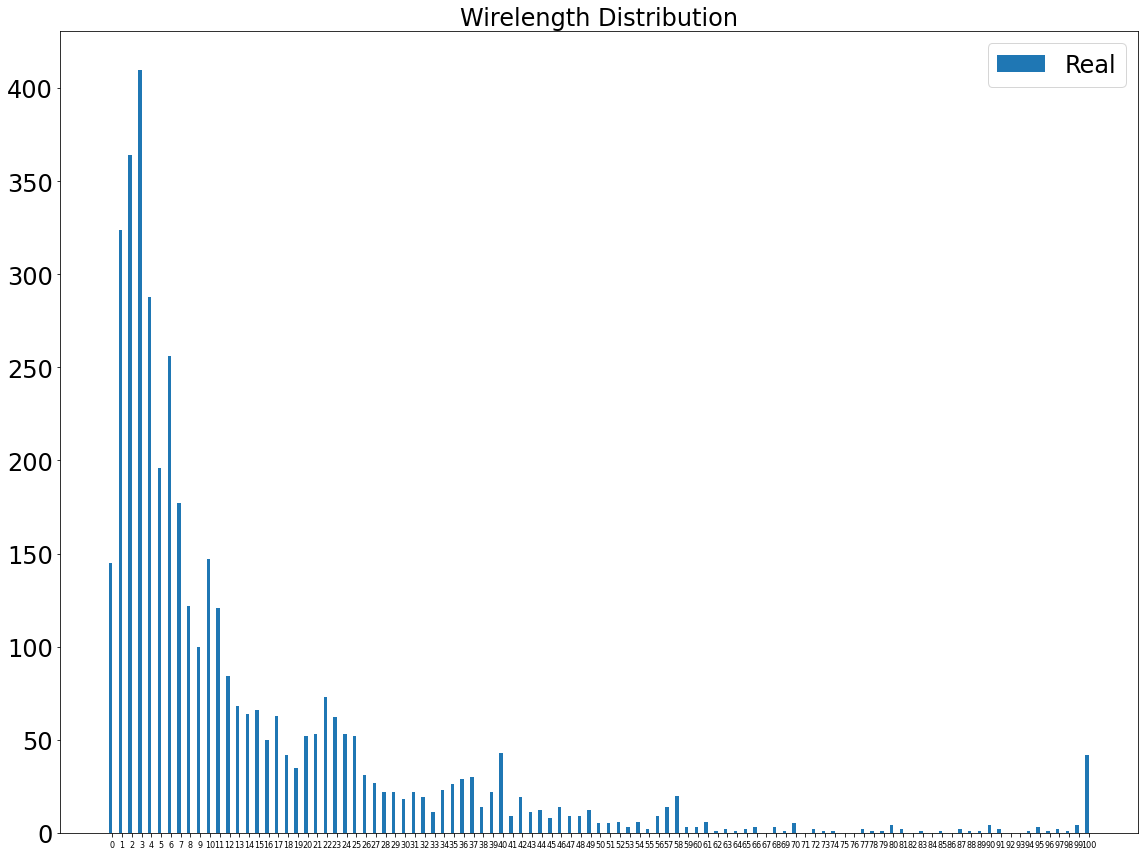

[1.20960e+06 1.20960e+06 1.20960e+06 ... 3.04886e+09 3.04886e+09
 3.04886e+09]
Num device: 4840
L min:1209600.0
L max:3048860000.0
Interval: 20889803.52


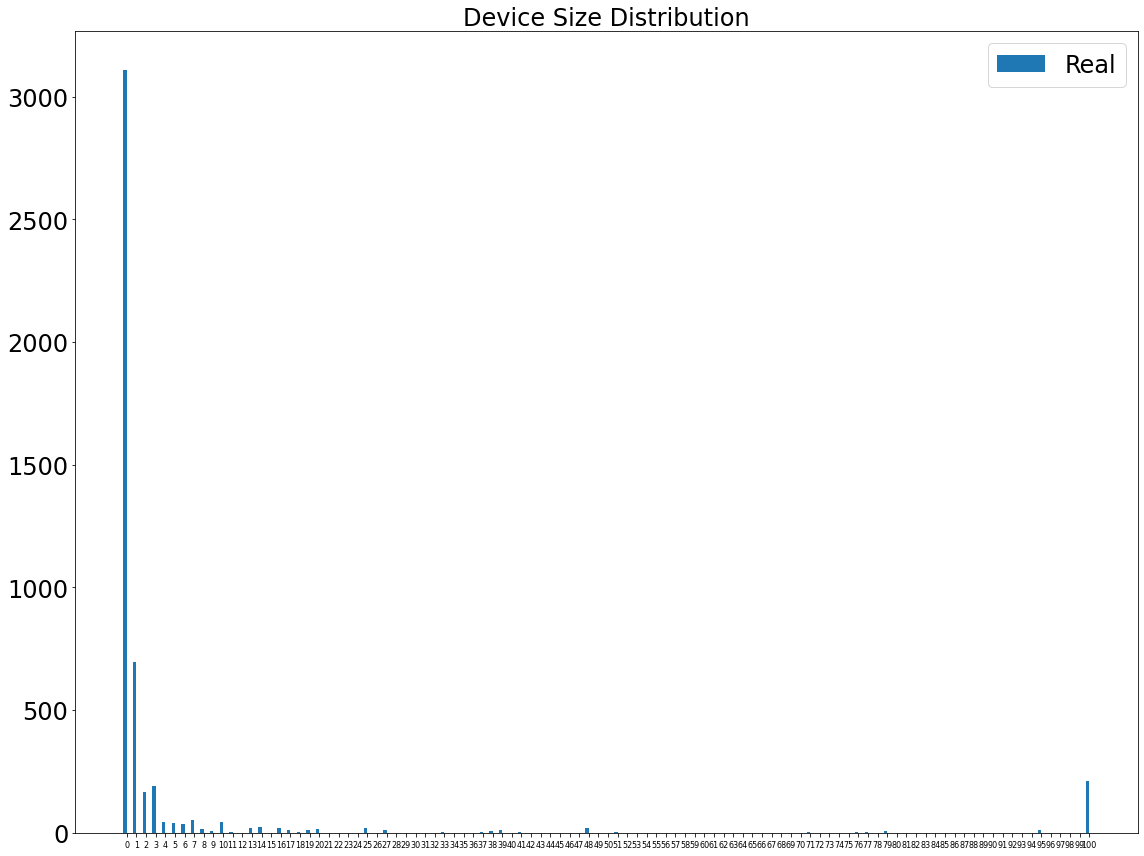

ALIGN(266)


In [4]:
%run ./Dataset_Generation_for_merging_cap_and_res.ipynb
#import import_ipynb
#import Dataset_Generation.ipynb
dataset = ALIGN(root='data_CapRes')

In [5]:
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset


train_dataset = dataset[0:240]
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = dataset[240:]
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(train_dataset)

ALIGN(240)


In [6]:
for i, data in enumerate(train_loader):
    print(i)
    print(data)
    print(data.edge_index_dict[('device', 'capres2net', 'net')])
    print(data.edge_index_dict[('net', 'net2capres', 'device')])
    break

0
HeteroDataBatch(
  device={
    x=[69, 5],
    batch=[69],
    ptr=[5]
  },
  net={
    y=[61],
    train_mask=[61],
    smallnet_mask=[61],
    largenet_mask=[61],
    x=[61, 5],
    batch=[61],
    ptr=[5]
  },
  (device, gate2net, net)={ edge_index=[2, 65] },
  (net, net2gate, device)={ edge_index=[2, 65] },
  (device, source2net, net)={ edge_index=[2, 142] },
  (net, net2source, device)={ edge_index=[2, 142] },
  (device, capres2net, net)={ edge_index=[2, 8] },
  (net, net2capres, device)={ edge_index=[2, 8] },
  (net, net2net, net)={ edge_index=[2, 40] }
)
tensor([[ 3,  1,  3,  1, 16, 16, 11, 11],
        [ 2, 11, 11, 14, 18, 21, 21, 26]])
tensor([[ 2, 11, 11, 14, 18, 21, 21, 26],
        [ 3,  1,  3,  1, 16, 16, 11, 11]])


In [7]:
class Hetero_Model (torch.nn.Module):
    
    def __init__(self, heads=2, hidden_channel=32):
        super().__init__()
        
        self.fc1_device = Linear(in_channels=5, out_channels=hidden_channel)
        self.fc1_net    = Linear(in_channels=5, out_channels=hidden_channel)
        
        self.hetero_conv1 = HeteroConv({
                    ('device', 'gate2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'source2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'capres2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2gate', 'device'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2source', 'device'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2capres', 'device'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5)
                    }, aggr='sum')
        self.bnm1_device         = BatchNorm(hidden_channel*2)
        self.bnm1_net            = BatchNorm(hidden_channel*2)
        
        self.hetero_conv2 = HeteroConv({
                    ('device', 'gate2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'source2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'capres2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2gate', 'device'):GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2source', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2capres', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2net', 'net'):GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5)
                    }, aggr='sum')
        self.bnm2_device         = BatchNorm(hidden_channel*2)
        self.bnm2_net            = BatchNorm(hidden_channel*2)
            
        self.hetero_conv3 = HeteroConv({
                    ('device', 'gate2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'source2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'capres2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2gate', 'device'):GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2source', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2capres', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2net', 'net'):GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5)
                    }, aggr='sum')
        self.bnm3_device         = BatchNorm(hidden_channel*2)
        self.bnm3_net            = BatchNorm(hidden_channel*2)
        
        self.fc1  = Linear(hidden_channel*2*3, hidden_channel)
        self.bnm4 = BatchNorm(hidden_channel)
        self.fc2  = Linear(hidden_channel, 1)
        
    
    def forward(self, x_dict, edge_index_dict):
        
        x_dict['device'] = self.fc1_device(x_dict['device'])
        x_dict['net']    = self.fc1_net(x_dict['net'])
        
        
        x_dict           = self.hetero_conv1(x_dict, edge_index_dict)
        x_dict['device'] = self.bnm1_device(x_dict['device'])
        x_dict['net']    = self.bnm1_net(x_dict['net'])
        x_dict['device'] = F.elu(x_dict['device'])
        x_dict['net']    = F.elu(x_dict['net'])
        h1               = F.elu(x_dict['net'])
        
                
        x_dict           = self.hetero_conv2(x_dict, edge_index_dict)
        x_dict['device'] = self.bnm2_device(x_dict['device'])
        x_dict['net']    = self.bnm2_net(x_dict['net'])
        x_dict['device'] = F.elu(x_dict['device'])
        x_dict['net']    = F.elu(x_dict['net'])
        h2               = F.elu(x_dict['net'])
        
                
        x_dict           = self.hetero_conv3(x_dict, edge_index_dict)
        x_dict['device'] = self.bnm3_device(x_dict['device'])
        x_dict['net']    = self.bnm3_net(x_dict['net'])
        x_dict['device'] = F.elu(x_dict['device'])
        x_dict['net']    = F.elu(x_dict['net'])
        h3               = F.elu(x_dict['net'])
        
        x = torch.cat((h1, h2, h3), dim=1) 
        
        x = self.fc1(x)
        x = F.elu(x)
        x = F.dropout(x, 0.5, self.training)
        x = self.fc2(x)
        x = F.elu(x)
        
        return x

In [8]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)
model = Hetero_Model().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)
criterion = nn.MSELoss()


cuda:1


In [9]:
#model.to(device)
#model.load_state_dict(torch.load('./HAT_Symmetric_CapRes.pth')['model_state_dict'])
#optimizer.load_state_dict(torch.load('./HAT_Symmetric_CapRes.pth')['optimizer_state_dict'])

#print(device)


In [10]:
model.train()
Model_Path = './HAT_Symmetric_CapRes.pth'

i = 0
for epoch in range(1000):
    model.train()
        
    for data in train_loader:
        
        optimizer.zero_grad()  
        data.to(device)
        out = model(data.x_dict, data.edge_index_dict).squeeze()
        
        loss = criterion(out[data.train_mask_dict['net']], data.y_dict['net'][data.train_mask_dict['net']])
        loss.backward()
        optimizer.step()
        
        #data.to('cpu')
        #torch.cuda.empty_cache()
    
    scheduler.step()
    if epoch%10 == 0:
        print(f'[{epoch + 1}] loss: {loss:.5f}')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, Model_Path)
    if epoch%100 == 0:
        print(f'[{epoch + 1}] lr: {optimizer.param_groups[0]["lr"]}')
    
    

[1] loss: 1816103680.00000
[1] lr: 0.005
[11] loss: 533096608.00000
[21] loss: 392847520.00000
[31] loss: 2353888768.00000
[41] loss: 535901632.00000
[51] loss: 478597312.00000
[61] loss: 12777123840.00000
[71] loss: 433822304.00000
[81] loss: 235560032.00000
[91] loss: 681555392.00000
[101] loss: 322048192.00000
[101] lr: 0.0034999999999999996
[111] loss: 1403813248.00000
[121] loss: 3729280256.00000
[131] loss: 444201184.00000
[141] loss: 1570430976.00000
[151] loss: 2837663232.00000
[161] loss: 817221184.00000
[171] loss: 349546976.00000
[181] loss: 564395392.00000
[191] loss: 609859072.00000
[201] loss: 1521103360.00000
[201] lr: 0.0024499999999999995
[211] loss: 238840368.00000
[221] loss: 83005120.00000
[231] loss: 522626400.00000
[241] loss: 1197381632.00000
[251] loss: 162022752.00000
[261] loss: 484958720.00000
[271] loss: 179056192.00000
[281] loss: 1457416448.00000
[291] loss: 428004256.00000
[301] loss: 295234976.00000
[301] lr: 0.0017149999999999995
[311] loss: 406577408.0

In [11]:
Model_Path = './HAT_Symmetric_CapRes.pth'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, Model_Path)

In [ ]:
model.load_state_dict(torch.load('./HAT_Symmetric_CapRes.pth')['model_state_dict'])
optimizer.load_state_dict(torch.load('./HAT_Symmetric_CapRes.pth')['optimizer_state_dict'])

In [12]:
model.eval()
test_acc_list = []
out_list = []
ans_list = []
model.to('cpu')

for data in test_loader:
    
    #print(data.x_dict)
    out = model(data.x_dict, data.edge_index_dict).squeeze()
    loss = criterion(out[data.train_mask_dict['net']], data.y_dict['net'][data.train_mask_dict['net']])
    print(loss)
    
    #out = torch.exp(out[data.train_mask_dict['net']]).detach().numpy()
    out = out[data.train_mask_dict['net']].detach().numpy()
    #print(out)
    
    #ans = torch.exp(data.y_dict['net'][data.train_mask_dict['net']]).detach().numpy()
    ans = data.y_dict['net'][data.train_mask_dict['net']].detach().numpy()
    #print(ans)
    
    mape = np.multiply(np.mean(np.divide(np.absolute(np.subtract(ans, out)), ans)), 100)
    mse = np.mean(np.absolute(np.subtract(ans, out)))
    print("MAPE: " + str(mape) + "%")
    print("MSE: " + str(mse))
    print()
    

    for i in range(out.shape[0]):
        if(ans[i] > 6):
            out_list.append(out[i])
            ans_list.append(ans[i])
    
        
#print(out_list)
#print(ans_list)

print(len(out_list))
print(len(ans_list))

out_list = np.array(out_list)
ans_list = np.array(ans_list) 
overall_mape = np.multiply(np.mean(np.divide(np.absolute(np.subtract(ans_list, out_list)), ans_list)), 100)
overall_mse = np.mean(np.absolute(np.subtract(ans_list, out_list)))
print("Overall MAPE: " + str(overall_mape) + "%")
print("Overall MSE: " + str(overall_mse))

tensor(65693124., grad_fn=<MseLossBackward0>)
MAPE: 69.95755434036255%
MSE: 6422.8984

tensor(19363044., grad_fn=<MseLossBackward0>)
MAPE: 68.94844174385071%
MSE: 3719.3525

tensor(27010406., grad_fn=<MseLossBackward0>)
MAPE: 38.8780415058136%
MSE: 4238.689

tensor(8.0825e+08, grad_fn=<MseLossBackward0>)
MAPE: 50.65867900848389%
MSE: 19970.361

tensor(1.2507e+09, grad_fn=<MseLossBackward0>)
MAPE: 266.08617305755615%
MSE: 29515.664

tensor(25918798., grad_fn=<MseLossBackward0>)
MAPE: 68.80610585212708%
MSE: 4455.0356

tensor(1.3691e+09, grad_fn=<MseLossBackward0>)
MAPE: 53.8532555103302%
MSE: 32975.742

tensor(4.7280e+09, grad_fn=<MseLossBackward0>)
MAPE: 60.151612758636475%
MSE: 53663.38

tensor(32395530., grad_fn=<MseLossBackward0>)
MAPE: 54.989033937454224%
MSE: 4747.3906

tensor(23095528., grad_fn=<MseLossBackward0>)
MAPE: 63.4501576423645%
MSE: 4175.6646

tensor(6.3881e+09, grad_fn=<MseLossBackward0>)
MAPE: 40.47710597515106%
MSE: 59146.3

tensor(3.0511e+08, grad_fn=<MseLossBackwar

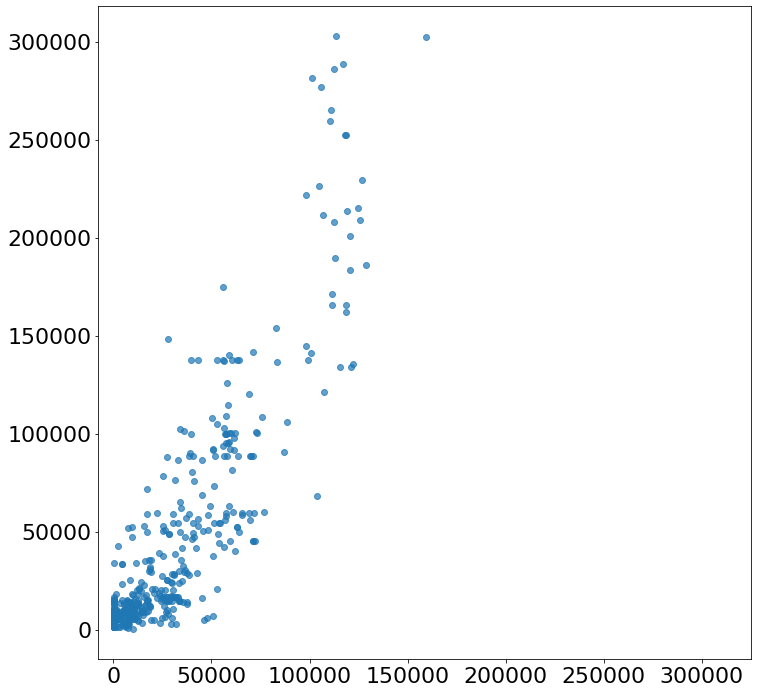

In [13]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize = (12, 12))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
ax.scatter(out_list, ans_list, alpha=0.7)
plt.axis('square')
plt.show()

In [14]:
N = 20

num_wire = len(out_list)
ans_sorted = np.sort(ans_list)
#out_sorted = np.sort(out_list) 
print("Num wire: " + str(num_wire))
    
L_min = ans_sorted[0]
L_max = ans_sorted[(num_wire-1) - int(0.05*num_wire)]
print("L min:" + str(L_min))
print("L max:" + str(L_max))
    
ans_label = np.zeros(num_wire)
out_label = np.zeros(num_wire)
interval = (L_max-L_min) / N
print("Interval: " + str(interval))
    
       
for i in range(N+1):
    interval_min = L_min + (i*interval)
    interval_max = L_min + ((i+1)*interval)
        
    if (i == N):
        ans_label = np.where((ans_list >= interval_min), i, ans_label)
        out_label = np.where((out_list >= interval_min), i, out_label)
    else:
        ans_label = np.where((ans_list >= interval_min) & (ans_list < interval_max), i, ans_label)
        out_label = np.where((out_list >= interval_min) & (out_list < interval_max), i, out_label)
            
#print(out_label)
#print(ans_label)
 
avg_value = np.zeros(N+1)
bin_num = np.zeros(N+1)
pred_avg_value = np.zeros(N+1)
pred_bin_num = np.zeros(N+1)
    
print("correlation: ")
    
for i in range(N+1):
    
    ans_mask = np.where(ans_label == i, True, False)
    bin_num[i] = len(ans_list[ans_mask])
    avg_value[i] = np.mean(ans_list[ans_mask])
        
    pred_mask = np.where(out_label == i, True, False)
    pred_bin_num[i] = len(out_list[pred_mask])
    pred_avg_value[i] = np.mean(out_list[pred_mask])

print(bin_num)
print(pred_bin_num)
    
#print(avg_value)
#print(pred_avg_value)
    
#print(np.corrcoef(avg_value, pred_avg_value))
      
    
print("MAPE:")
    
mape = np.multiply(np.divide(np.absolute(np.subtract(ans_list, out_list)), ans_list), 100)
   
mape_list = []
for i in range(N+1):
    out_mask = np.where(out_label == i, True, False)
    mape_list.append(np.mean(mape[out_mask]))
        
#print(mape)
print(mape.mean())
print(mape_list)
    
    
print("====================================")
#break

Num wire: 416
L min:320.0
L max:186240.0
Interval: 9296.0
correlation: 
[113.  98.  23.  20.  15.  29.  18.   5.   5.  18.  16.   6.   2.   2.
  13.   5.   1.   3.   2.   1.  21.]
[130.  61.  41.  47.  24.  22.  37.  14.   4.   2.   5.   9.  14.   5.
   0.   0.   0.   1.   0.   0.   0.]
MAPE:
79.01639
[82.19516, 98.71547, 94.98139, 103.47901, 83.282646, 95.25965, 34.71459, 32.52897, 35.860813, 10.265574, 41.598766, 45.772987, 40.94077, 33.465683, nan, nan, nan, 47.28573, nan, nan, nan]


/edahome/msedalab/deyuan/anaconda3/envs/GNN_PyG/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/edahome/msedalab/deyuan/anaconda3/envs/GNN_PyG/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


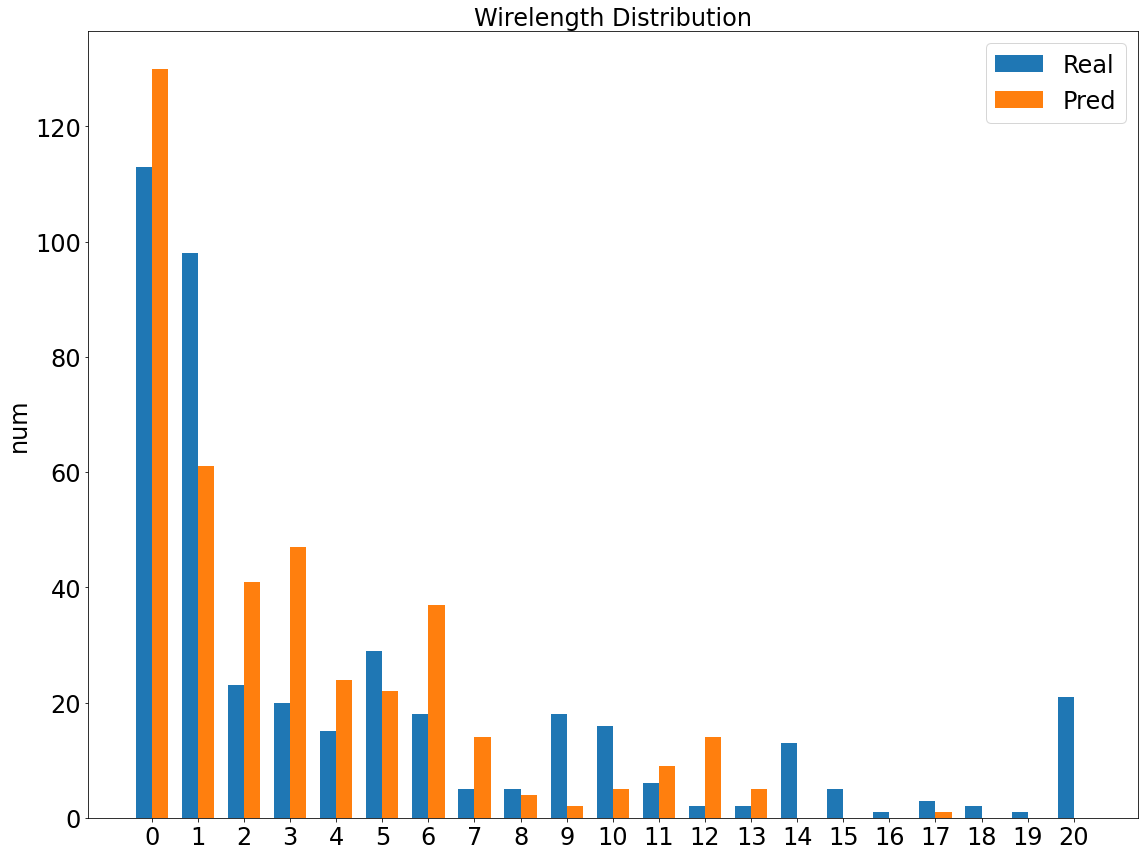

In [15]:
import matplotlib.pyplot as plt
labels = [i for i in range(N+1)]

x = np.arange(N+1)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bin_num, width, label='Real')
rects2 = ax.bar(x + width/2, pred_bin_num, width, label='Pred')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('num', fontsize=24)
ax.set_title('Wirelength Distribution', fontsize=24)
plt.yticks(fontsize=24)
ax.set_xticks(x, labels, fontsize=24)
ax.legend(loc='best', fontsize=24)


fig.set_size_inches(16, 12)
fig.tight_layout()

plt.show()


In [ ]:
labels = [i for i in range(20)]



x = np.arange(20)  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mape_list, width, label='MAPE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('%', fontsize=24)
ax.set_title('MAPE', fontsize=24)
plt.yticks(fontsize=24)
ax.set_xticks(x, labels, fontsize=24)
ax.legend(loc='best', fontsize=24)


fig.set_size_inches(16, 12)
fig.tight_layout()

plt.show()